In [1]:
import os
import gc

os.chdir('../../')

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from global_code.util import reduce_mem_usage
import matplotlib.pyplot as plt
import seaborn as sns
from global_code.util import reduce_mem_usage, clf_metric_report, compute_and_plot_permutation_importance, plot_pr_calib_curve, plot_dis_probs, plot_shap_values
import optuna
import arfs
import shap
import json
import joblib

sns.set(style='whitegrid')

/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read the parquet file located at `./week_1/data/processed/feature_engineering_dataset.parquet`

In [8]:
df = pd.read_parquet('./week_1/data/processed/feature_engineering_dataset_2.parquet')
non_features_list = ['Id', 'customer_id','name','date_of_birth','address','date','touchpoints','csat_scores','Usage','churn','next_date','days_diff']
df = df.drop(non_features_list, axis=1)
df.info()           

<class 'pandas.core.frame.DataFrame'>
Index: 5286530 entries, 2961532 to 5286529
Columns: 170 entries, Id to churn_18_months
dtypes: bool(1), datetime64[ns](2), datetime64[us](1), float64(131), int64(25), object(10)
memory usage: 6.7+ GB


### Preprocessing

In [9]:
cat_features = ['job', 'country', 'broad_job_category']
for col in cat_features:
    df[col] = df[col].astype('str').fillna('')
    df[col] = df[col].astype('category')

In [10]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 6760.85 MB
Memory usage after optimization is: 6730.60 MB
Decreased by 0.4%


In [11]:
df.dtypes

Id                                  int64
customer_id                         int64
interest_rate                     float64
name                               object
country                          category
                                ...      
this_week_crypto_volume           float64
churn_365                           int64
churn_420                           int64
churn_date                 datetime64[ns]
churn_18_months                   float16
Length: 170, dtype: object

### Train, Validation, Test Split

In [13]:
# target - Inactivity 365 days 
#train_max_date = '2022-01-01'
#validation_max_date = '2023-01-01'
#test_start_date = '2024-01-01'
#target = 'churn_365'

# target - no activity afeter 2022-06-01
#train_max_date = '2019-06-01'
#validation_max_date = '2022-06-01'
#test_start_date = '2024-01-01'
#target = 'churn_18_months'

# target - inactivity >= 420 days target
train_max_date = '2021-10-01'
validation_max_date = '2022-10-01'
test_start_date = '2024-01-01'
target = 'churn_420'


# PROMPT: break this list in lines, add comments to group the features in categories
features = [
    # Basic customer information
    "interest_rate", "country", "customer_age", "job", "broad_job_category", "tenure", "from_competitor",
    
    # Transaction counts
    "atm_transfer_in", "atm_transfer_out", "bank_transfer_in", "bank_transfer_out", 
    "crypto_in", "crypto_out",
    
    # Transaction volumes
    "bank_transfer_in_volume", "bank_transfer_out_volume",
    "crypto_in_volume", "crypto_out_volume",
    
    # Customer service and interactions
    "complaints", "churn_due_to_fraud", "model_predicted_fraud",
    "appointment", "email", "phone", "whatsapp", "days_between",
    
    # Historical interaction metrics
    "prior_emails", "prior_appointments", "prior_phones", "prior_whatsapps",
    "prior_touchpoints", "prior_count",
    
    # Historical balance and transaction metrics
    "prior_crypto_balance", "prior_bank_balance", "prior_mean_balance",
    "prior_sum_days_between", "prior_std_days_between", "prior_mean_days_between",
    "prior_min_days_between", "prior_max_days_between",
    
    # Prior mean transaction metrics
    "prior_mean_bank_transfer_in", "prior_mean_bank_transfer_out",
    "prior_mean_crypto_in", "prior_mean_crypto_out",
    "prior_mean_bank_transfer_in_volume", "prior_mean_bank_transfer_out_volume",
    "prior_mean_crypto_in_volume", "prior_mean_crypto_out_volume",
    
    # Prior sum volume metrics
    "prior_sum_bank_transfer_in_volume", "prior_sum_bank_transfer_out_volume",
    "prior_sum_crypto_in_volume", "prior_sum_crypto_out_volume",
    
    # 10-day window metrics
    "prior_10D_count", "prior_10D_sum_days_between", "prior_10D_mean_days_between",
    "prior_10D_std_days_between", "prior_10D_max_days_between", "prior_10D_min_days_between",
    "prior_10D_mean_bank_transfer_in", "prior_10D_mean_bank_transfer_out",
    "prior_10D_mean_crypto_in", "prior_10D_mean_crypto_out",
    "prior_10D_mean_bank_transfer_in_volume", "prior_10D_mean_bank_transfer_out_volume",
    "prior_10D_mean_crypto_in_volume", "prior_10D_mean_crypto_out_volume",
    "prior_10D_sum_bank_transfer_in_volume", "prior_10D_sum_bank_transfer_out_volume",
    "prior_10D_sum_crypto_in_volume", "prior_10D_sum_crypto_out_volume",
    "prior_10D_bank_balance", "prior_10D_mean_balance",
    
    # 90-day window metrics
    "prior_90D_count", "prior_90D_sum_days_between", "prior_90D_mean_days_between",
    "prior_90D_std_days_between", "prior_90D_max_days_between", "prior_90D_min_days_between",
    "prior_90D_mean_bank_transfer_in", "prior_90D_mean_bank_transfer_out",
    "prior_90D_mean_crypto_in", "prior_90D_mean_crypto_out",
    "prior_90D_mean_bank_transfer_in_volume", "prior_90D_mean_bank_transfer_out_volume",
    "prior_90D_mean_crypto_in_volume", "prior_90D_mean_crypto_out_volume",
    "prior_90D_sum_bank_transfer_in_volume", "prior_90D_sum_bank_transfer_out_volume",
    "prior_90D_sum_crypto_in_volume", "prior_90D_sum_crypto_out_volume",
    "prior_90D_bank_balance", "prior_90D_mean_balance",
    
    # 180-day window metrics
    "prior_180D_count", "prior_180D_sum_days_between", "prior_180D_mean_days_between",
    "prior_180D_std_days_between", "prior_180D_max_days_between", "prior_180D_min_days_between",
    "prior_180D_mean_bank_transfer_in", "prior_180D_mean_bank_transfer_out",
    "prior_180D_mean_crypto_in", "prior_180D_mean_crypto_out",
    "prior_180D_mean_bank_transfer_in_volume", "prior_180D_mean_bank_transfer_out_volume",
    "prior_180D_mean_crypto_in_volume", "prior_180D_mean_crypto_out_volume",
    "prior_180D_sum_bank_transfer_in_volume", "prior_180D_sum_bank_transfer_out_volume",
    "prior_180D_sum_crypto_in_volume", "prior_180D_sum_crypto_out_volume",
    "prior_180D_bank_balance", "prior_180D_mean_balance",
    
    # 365-day window metrics
    "prior_365D_count", "prior_365D_sum_days_between", "prior_365D_mean_days_between",
    "prior_365D_std_days_between", "prior_365D_max_days_between", "prior_365D_min_days_between",
    "prior_365D_mean_bank_transfer_in", "prior_365D_mean_bank_transfer_out",
    "prior_365D_mean_crypto_in", "prior_365D_mean_crypto_out",
    "prior_365D_mean_bank_transfer_in_volume", "prior_365D_mean_bank_transfer_out_volume",
    "prior_365D_mean_crypto_in_volume", "prior_365D_mean_crypto_out_volume",
    "prior_365D_sum_bank_transfer_in_volume", "prior_365D_sum_bank_transfer_out_volume",
    "prior_365D_sum_crypto_in_volume", "prior_365D_sum_crypto_out_volume",
    "prior_365D_bank_balance", "prior_365D_mean_balance",
    
    # 450-day window metrics
    "prior_450D_count", "prior_450D_sum_days_between", "prior_450D_mean_days_between",
    "prior_450D_std_days_between", "prior_450D_max_days_between", "prior_450D_min_days_between",
    "prior_450D_mean_bank_transfer_in", "prior_450D_mean_bank_transfer_out",
    "prior_450D_mean_crypto_in", "prior_450D_mean_crypto_out",
    "prior_450D_mean_bank_transfer_in_volume", "prior_450D_mean_bank_transfer_out_volume",
    "prior_450D_mean_crypto_in_volume", "prior_450D_mean_crypto_out_volume",
    "prior_450D_sum_bank_transfer_in_volume", "prior_450D_sum_bank_transfer_out_volume",
    "prior_450D_sum_crypto_in_volume", "prior_450D_sum_crypto_out_volume",
    "prior_450D_bank_balance", "prior_450D_mean_balance",
    
    # Current week metrics
    "this_week_bank_volume", "this_week_crypto_volume"
]

train_df = df.loc[df['date'] < train_max_date, :]
validation_df = df.loc[(df['date'] >= train_max_date) & (df['date'] < validation_max_date), :]

# Get Train and Validation Subsamples to speed up the process
_, train_df = train_test_split(train_df, test_size=0.10, random_state=42, stratify=train_df[target])
calibration_df, validation_df = train_test_split(validation_df, test_size=0.20, random_state=42, stratify=validation_df[target])

X_train, y_train = train_df.loc[:, features], train_df.loc[:, target]
X_validation, y_validation = validation_df.loc[:,features], validation_df.loc[:,target]
X_calibration, y_calibration = calibration_df.loc[:,features], calibration_df.loc[:,target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_validation.shape, y_validation.shape)

KeyError: "['prior_10D_sum_bank_transfer_out_volume', 'prior_90D_sum_bank_transfer_out_volume', 'prior_180D_sum_bank_transfer_out_volume', 'prior_365D_sum_bank_transfer_out_volume', 'prior_450D_sum_bank_transfer_out_volume'] not in index"

In [ ]:
print('Train Values count:\n', y_train.value_counts())
print(y_train.value_counts(normalize=True))

In [ ]:
print('Train Values count:\n', y_validation.value_counts())
print(y_validation.value_counts(normalize=True))

### Train a Vanilla Baseline CatBoost Model

In [ ]:
# Using PRAUC Use Weights False to not inflat the PRAUC metric
model = CatBoostClassifier(iterations=1000, auto_class_weights='Balanced', eval_metric='PRAUC:use_weights=false', cat_features=cat_features, verbose=True) 

print('Traning the model...')
model.fit(X_train, y_train, eval_set=(X_validation, y_validation), early_stopping_rounds=100)

print('Evaluating the model...')
y_pred = model.predict_proba(X_validation)[:, 1]
clf_metric_report(y_pred, y_validation)

In [ ]:
# Permutation importance
feature_importance = compute_and_plot_permutation_importance(model, X_validation, y_validation, features)


In [ ]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred, y_validation)

In [ ]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred, y_validation)

### Feature Selection with Boruta

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
Leshy iteration:  90%|█████████ | 9/10 [01:42<00:11, 11.39s/it]
The Leshy or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.




Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	27
Tentative: 	29
Rejected: 	48
All relevant predictors selected in 00:01:42.98


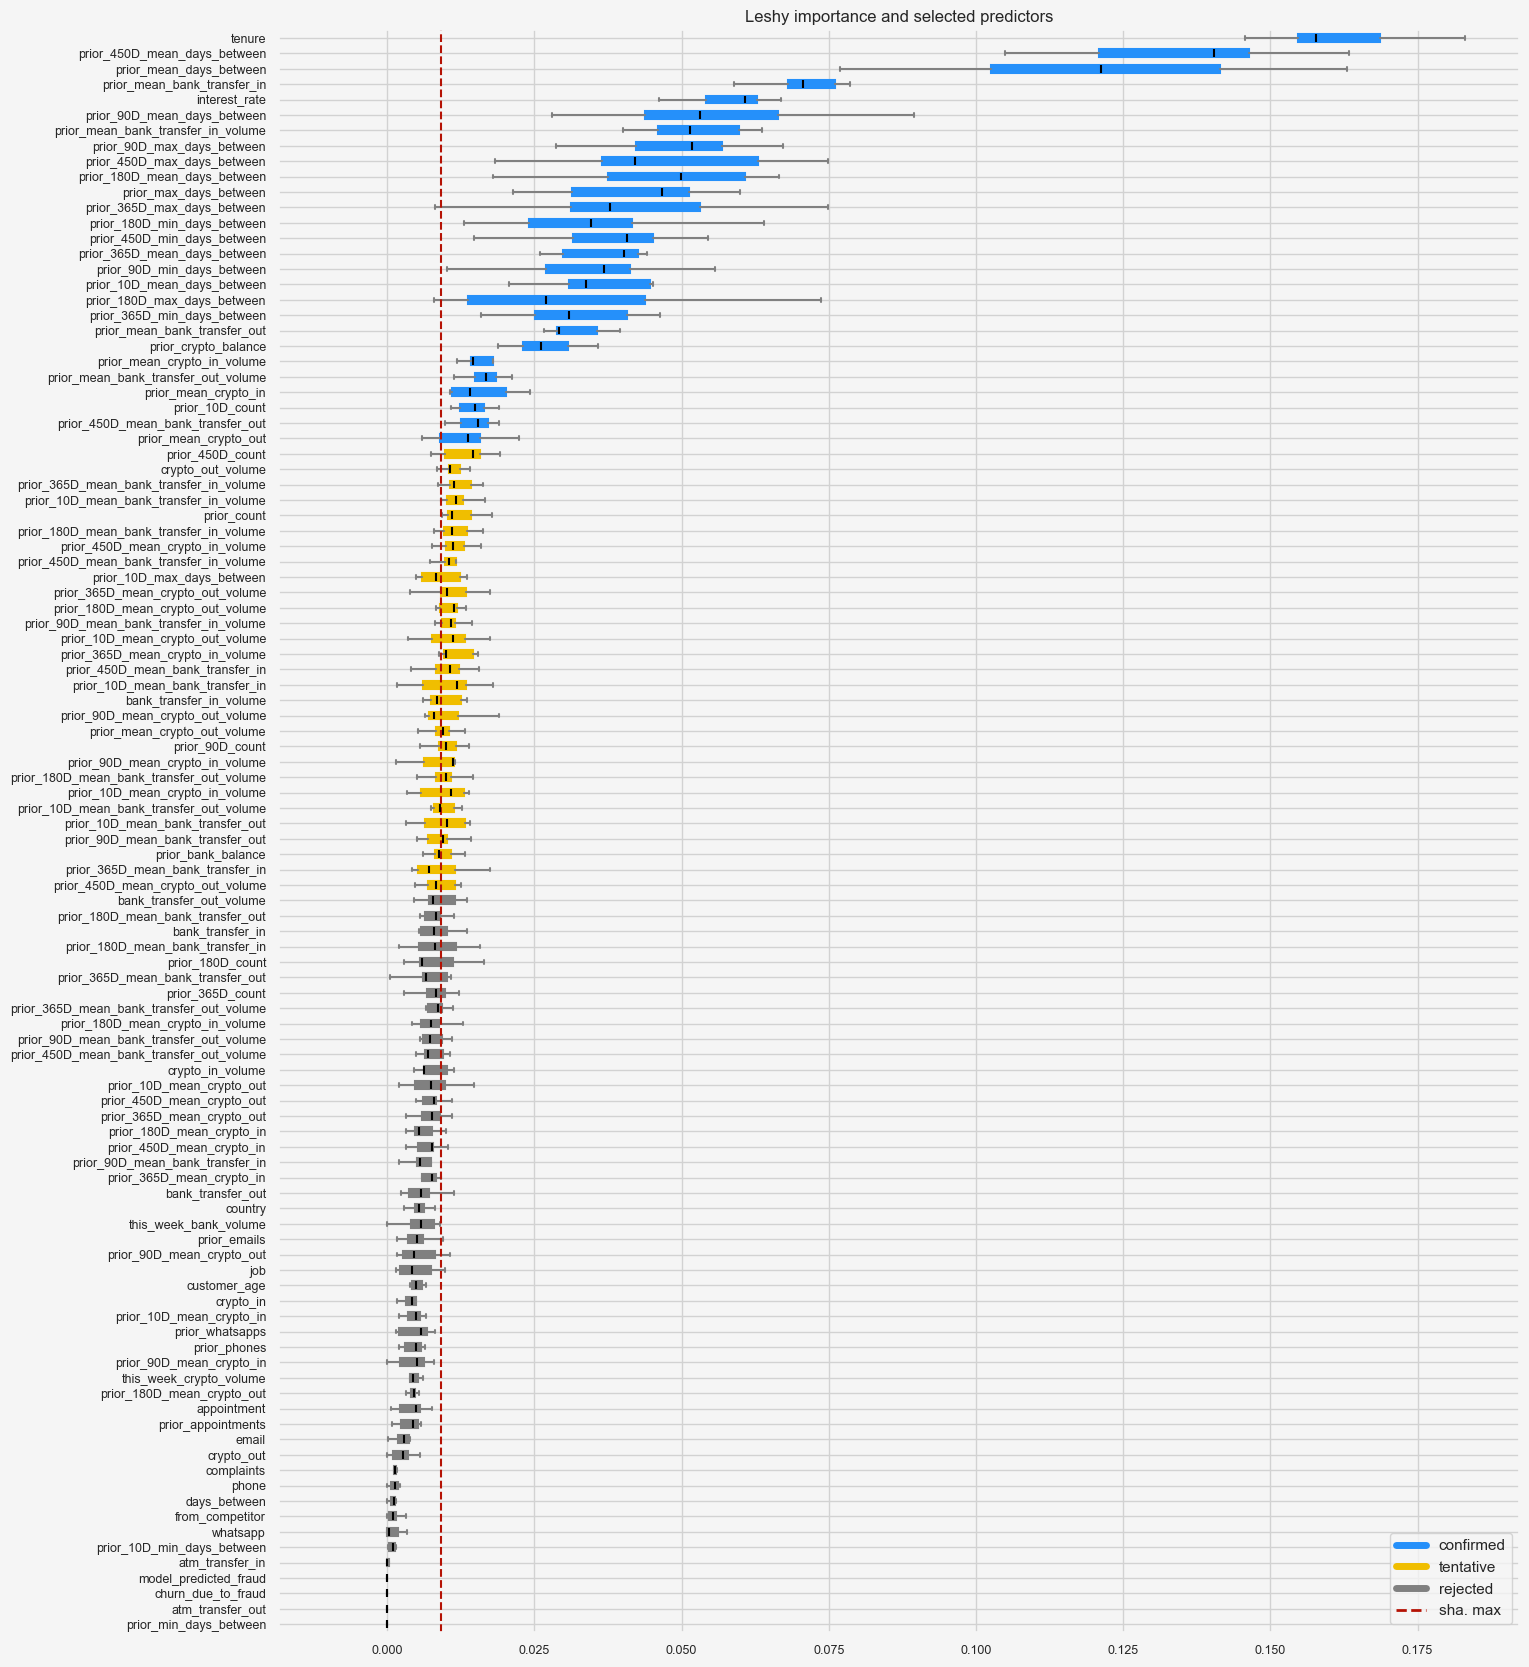

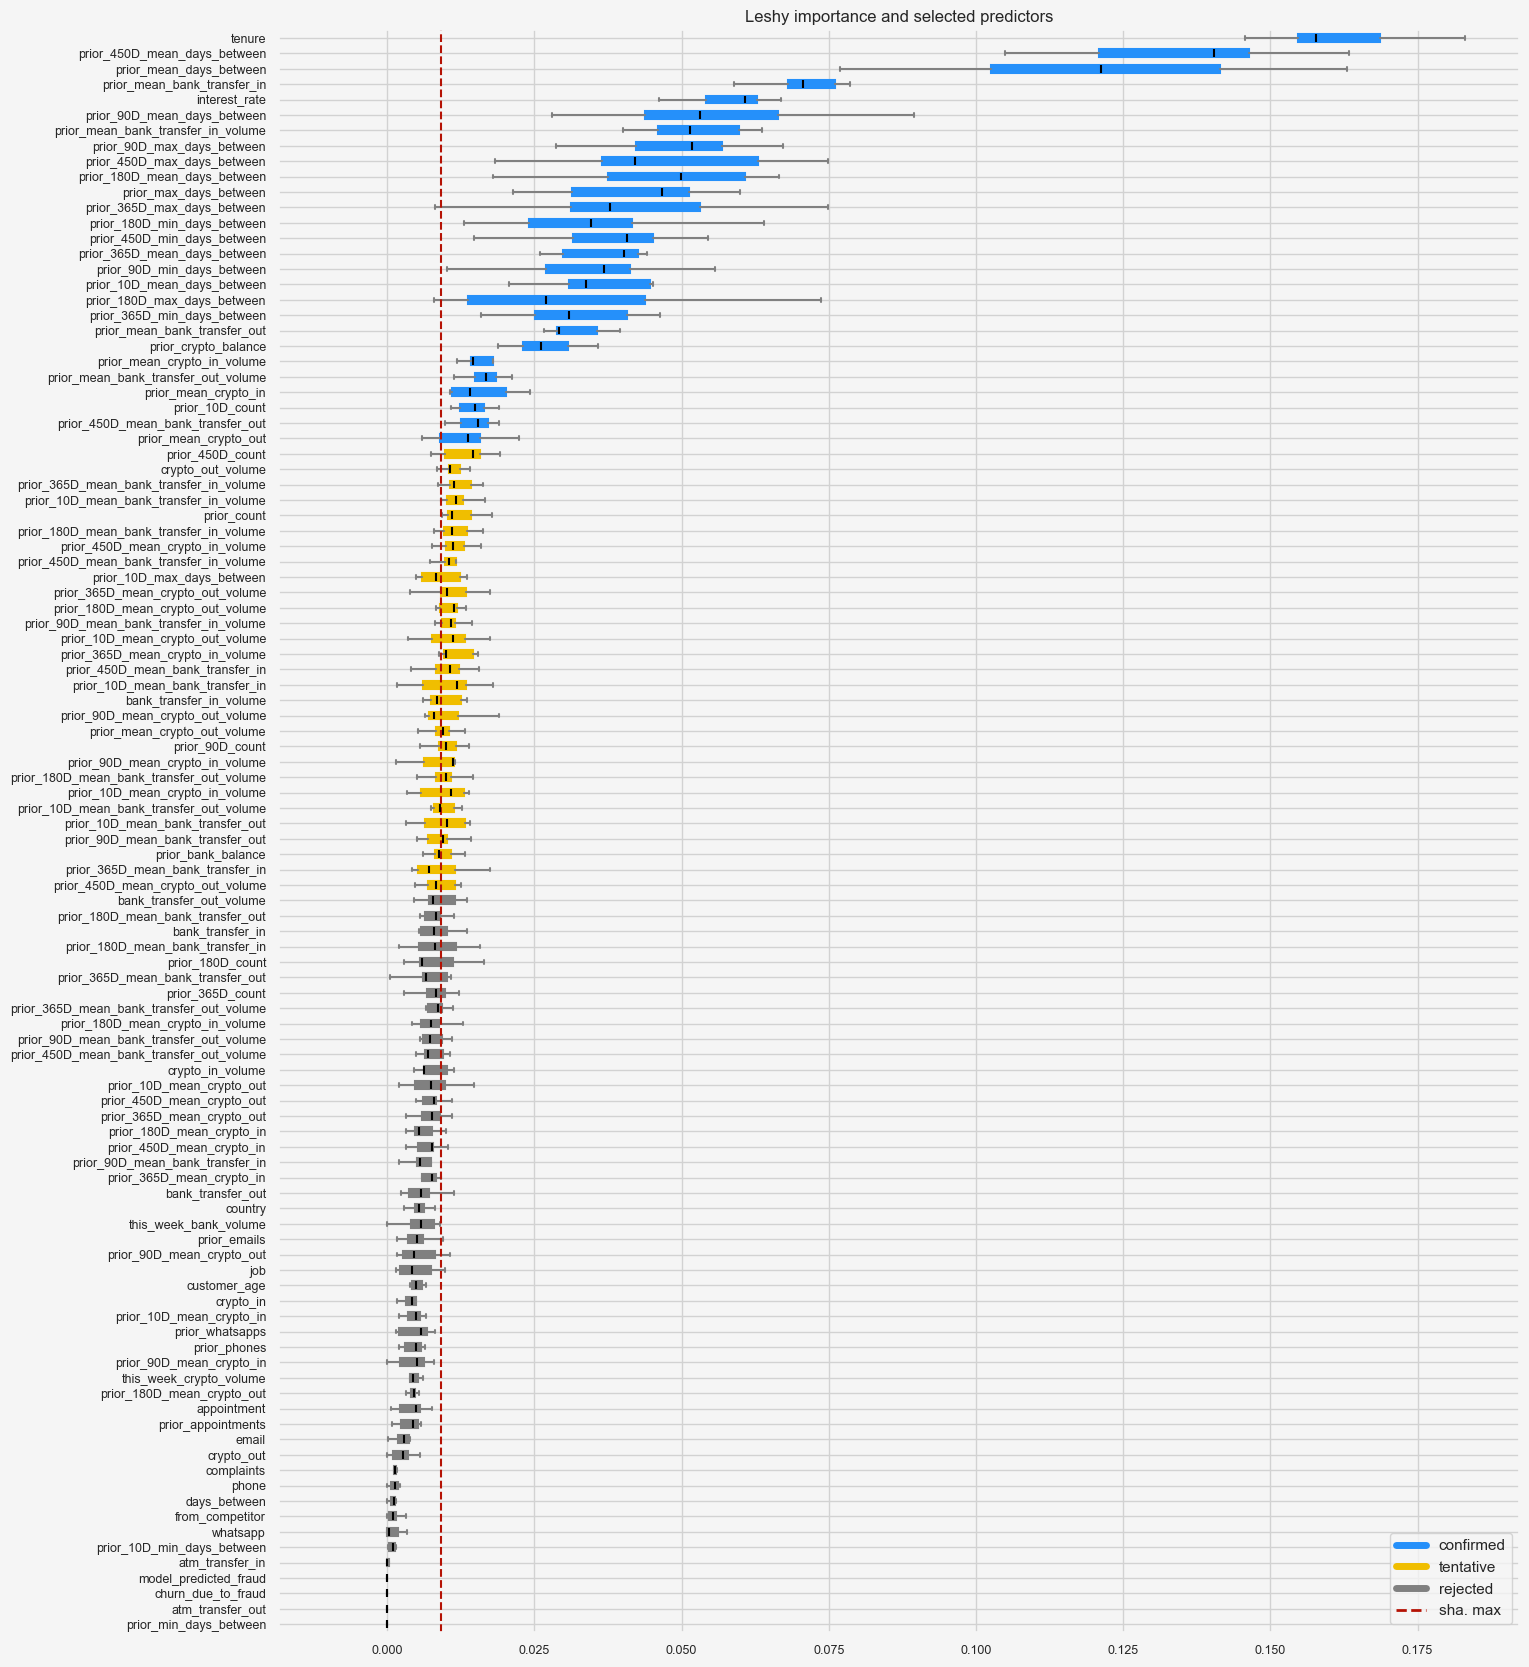

In [42]:
from arfs.feature_selection import GrootCV
from lightgbm import LGBMClassifier
import arfs.feature_selection.allrelevant as arfsgroot

# untuned, this is just a set of "reasonable defaults" to get better feature selection
params = {
    'random_strength': 1,
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'eval_metric': 'PRAUC',
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    'verbose': False 
}

model = CatBoostClassifier(**params) 

feat_selector = arfsgroot.Leshy(
    model, n_estimators=150, verbose=1, max_iter=10, random_state=42, importance="fastshap",
)

feat_selector.fit(X_train, y_train)

In [ ]:
selected_features = feat_selector.get_feature_names_out()
feat_selector.plot_importance()

# Save the selected features
with open('./week_1/data/processed/selected_features_list.json', 'w') as f:
    json.dump(selected_features.tolist(), f)

In [ ]:
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")

### Train a Vanilla CatBoost Model with Selected Features

In [ ]:
cat_features_selected = [feature for feature in selected_features if feature in cat_features]
model_selected = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='PRAUC:use_weights=false', cat_features=cat_features, verbose=True)
model_selected.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation))

y_pred_selected = model_selected.predict_proba(X_validation[selected_features])[:, 1]

# Model metrics report
clf_metric_report(y_pred_selected, y_validation)

In [ ]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_selected, y_validation)

In [ ]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_selected, y_validation)

In [ ]:
# SHAP Values
shape_explainer = shap.Explainer(model_selected)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

In [ ]:
# Permutation importance
feature_importance = compute_and_plot_permutation_importance(model, X_validation[selected_features], y_validation, selected_features)

### Perform Optuna Hyperparameter Tuning

In [ ]:
# https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm
# params = {'depth': [2, 6, 10],
#           'learning_rate' : [0.01, 0.05, 0.08, 0.1,0.5],
#          'l2_leaf_reg': [1, 3, 5, 7, 9],
#          'iterations': [50, 100, 150, 300, 500, 750, 1000]}


params = {
    'random_strength': 1,
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'eval_metric': 'PRAUC',
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    'verbose': False 
}


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 100, 150, 300, 500, 750, 1000),
        'max_depth': trial.suggest_int('depth', 4, 8, 10, 14),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8, 1.0),
        'eval_metric': 'PRAUC',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        #'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e-1),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced', None]),
        'cat_features': cat_features_selected,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation), early_stopping_rounds=100)
    y_pred = model.predict_proba(X_validation[selected_features])[:, 1]
    return average_precision_score(y_validation, y_pred)

study = optuna.create_study(direction='maximize')

# Optimize for 1 hour 
study.optimize(objective, timeout=3600)

best_params = study.best_params
print(f'Best parameters: {best_params}')

In [ ]:
# Save the best parameters to a JSON file
best_params_path = './week_1/data/model/best_params.json'
with open(best_params_path, 'w') as f:
    json.dump(best_params, f, indent=4)

### Retrain the Model with the Best Parameters

In [ ]:
if best_params == None: 
    best_params = {
        'random_strength': 1,
        'learning_rate': 0.02,
        'max_depth': 8,
        'colsample_bylevel': 0.8,
        'subsample': 0.7,
        'eval_metric': 'PRAUC',
        'random_seed': 42,
        'auto_class_weights': 'Balanced',
        'verbose': False 
    }


model_best = CatBoostClassifier(**best_params)
model_best.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation))

y_pred_best = model_best.predict_proba(X_validation[selected_features])[:, 1]

# Model metrics report
clf_metric_report(y_pred_best, y_validation)

In [ ]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_selected, y_validation)

In [ ]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_selected, y_validation)


In [ ]:
# SHAP Values
shape_explainer = shap.Explainer(model_selected)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

In [ ]:
# Permutation importance
feature_importance = compute_and_plot_permutation_importance(model_best, X_validation[selected_features], y_validation, metric='average_precision')

### Perform Model Calibration

In [ ]:
calibrated_model = CalibratedClassifierCV(model_best, method='sigmoid')
calibrated_model.fit(X_calibration[selected_features], y_calibration)

y_pred_calibrated = calibrated_model.predict_proba(X_validation[selected_features])[:, 1]
clf_metric_report(y_pred_best, y_validation)

In [ ]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_selected, y_validation)

In [ ]:
# Save the calibrated model
model_path = './week_1/model/calibrated_model.joblib'
joblib.dump(calibrated_model, model_path)

print(f"Calibrated model saved to: {model_path}")